## Intuiciones respecto a la relacion entre bias / variance / underfitting y overfitting

Vinculo entre el sesgo, variancia, underfitting y overfitting.
**Alto sesgo se relaciona con el underfitting**.

Si nuestros datos de entrenamiento son muy pocos nuestra máquina no será capaz de generalizar el conocimiento y estará incurriendo en underfitting. Mientras que **cuando “sobre-entrenamos”** nuestro modelo y caemos en el overfitting, nuestro algoritmo estará considerando como válidos sólo los datos idénticos a los de nuestro conjunto de entrenamiento –incluidos sus defectos– y siendo incapaz de distinguir entradas buenas como fiables si se salen un poco de los rangos ya prestablecidos.

Depende de la distribución de nuestra nube de puntos. Si se tratara de una distibución no lineal y busco ajustarla con un modelo lineal estaria incurriendo en el underfitting, mientras que el overfitting es el aprendisaje de una función que matchea todos los puntos de a distribución.

Generemos esto con un dataset sintético con una relacion cuadratica entre `x` e `y`

Sampleo x,y, un error. Para unos datos muestrales S = sample_data(m)

In [1]:
import numpy as np

def sample_data(size=100, x_matrix=False, min_x=-2.5, max_x=2.5):
    x = (np.random.random(size=size) - 0.5 ) * (max_x - min_x)
    x.sort() # util para graficar
    y = x ** 2 + x + np.random.normal(0, 1, size=size)#La normal 0.1 como ruido. 
    if x_matrix:
        x = x.reshape((-1,1))
    return x, y

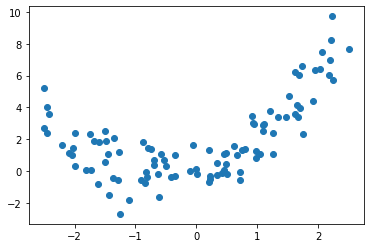

In [2]:
import matplotlib.pyplot as plt

X, y = sample_data(size=100, x_matrix=True)
plt.scatter(X, y)

Si la hago nuevamente, sigue el mismo patron pero me dara otros datos. 

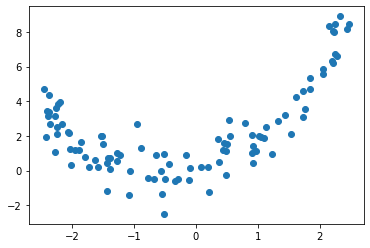

In [27]:
X, y = sample_data(size=100, x_matrix=True)
plt.scatter(X, y)

In [28]:
X.shape #es una matriz para que sklearn lo pueda usar. 

(100, 1)

In [29]:
y.shape

(100,)

# Underfitting

Vamos a ajustar esta función cuadratica con una regresion lineal
Cuando entrenamos un modelo que no tiene la capacidad para ajustarse a los datos que tenemos. Por lo que haremos un modelo lineal. 

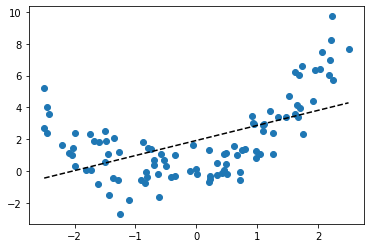

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y)

m, M = X.min(), X.max()

plt.plot([m, M], lr.predict([[m], [M]]), '--k')#Una linea recta entre dos puntos.
plt.scatter(X, y)

Este es un caso típico de underfitting, la capacidad del modelo no es suficiente para explicar los datos. No representa para nada lo que esta ocurriendo, notese la pendiente negativa en valores negativos de x, mientras que el modelo predice una pendiente positiva. 

Voy a tener que hacer repetidas veces: Elegir un dataset, entrenar un modelo y evaluar el erro. 

### Como se comporta con una parte de la distribución que nunca vio?

Vamos a evaluar la regresion lineal en un intervalo de datos que nunca vio, que involucran al `[-5, 5]` en lugar de `[-2.5, 2.5]` con lo que fue entrenado

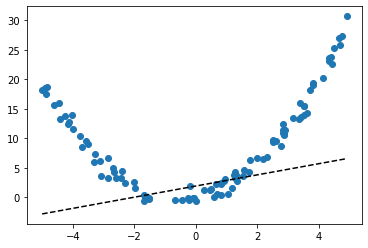

In [4]:
oos_X, oos_y = sample_data(min_x=-5, max_x=5, x_matrix=True) #oos: Out of sample. que vaya de -5 a 5

m, M = oos_X.min(), oos_X.max()
plt.plot([m, M], lr.predict([[m], [M]]), '--k')

plt.scatter(oos_X, oos_y)

La prediccion esta determinada por el sesgo que introdujimos nosotros. Este sesgo viene al determinar que el espacio de modelos que vamos a explorar, corresponde solo al de las funciones lineales en x

# Fiteamos muchos modelos lineales

Veamos como varian las predicciones si entrenamos muchos modelos lineales.

Podemos ver que el error es sistemáticamente alto

In [5]:
def sample_predictions(model, x, iters=100):
    """
    Toma `iters` muestras de datos, entrena un modelo con esos datos 
    Devuelve las predicciones de los modelos
    """
    ys_hat = []
    for _ in range(iters):
        X_train, y_train = sample_data(100, x_matrix=True)#Sampleo
        model.fit(X_train, y_train)#Entreno el modelo
        ys_hat.append(model.predict(x))#Hago predicciones. 
    return np.asarray(ys_hat)

In [6]:
def expected_prediction(model, x, iters=100):
    return sample_predictions(model, x, iters=iters).mean(axis=0)#Predigo muchas veces y tomo el modelo. 

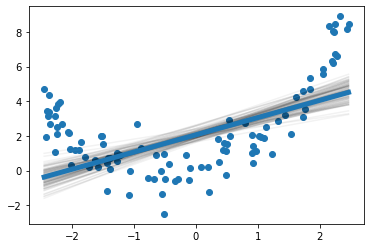

In [30]:
#El data set es el mismo(la nube de puntos)
#Las rectas son las distintas predicciones, con distinto nivel de ruido.

ys = sample_predictions(LinearRegression(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(X, expected_prediction(LinearRegression(), X), lw=5)

Podemos ver que si bien con distintos samples de los datos se obtienen diferentes modelos, son todos bastante parecidos entre si, y hacen predicciones similares (baja varianza). La varianza es sobre el error. 

# Cambiando regresion lineal por arbol de decisión

In [8]:
from sklearn.tree import DecisionTreeRegressor
from ipywidgets import interact, widgets #Te importas el scroll

def draw(min_samples_leaf):
    dt = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf).fit(X, y)

    plt.plot(X, dt.predict(X), '--k')
    plt.scatter(X, y)
    
interact(
    draw, 
    min_samples_leaf=widgets.IntSlider(min=1, max=50, step=1, value=1)
);

interactive(children=(IntSlider(value=1, description='min_samples_leaf', max=50, min=1), Output()), _dom_class…

Si llevo el min_sample a 1 el modelo de arbol se memoriza el dataset. Puedes seleccionar la cantidad de datos por Hoja del arbol para que realice un buen ajuste a la nube de puntos. Si lo subes mucho terminas teniendo un underfitting. 

#### Que pasa si lo miramos con observaciones fuera del rango entrenado?

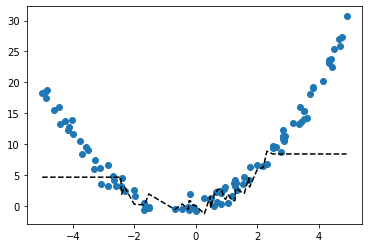

In [32]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(min_samples_leaf=1).fit(X, y)
plt.plot(oos_X, dt.predict(oos_X), '--k')
plt.scatter(oos_X, oos_y)

Tiene una distribucion bastante extraña 

Podemos ver como se ajusta a la perfeccion a los datos

# Haciendo muchas predicciones

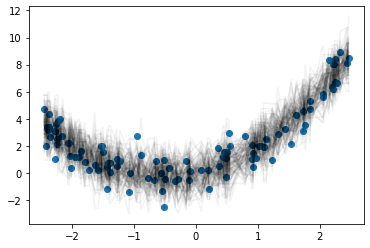

In [33]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

Lo oscuro es donde el modelo esta haciendo cosas, se observa muchisima varianza. 

Podemos ver que al tomar muchas muestras los modelos terminan cubriendo la zona de alta densidad de bolitas

Podemos ver que el modelo esperado se parece mucho a la funcion que genera los datos

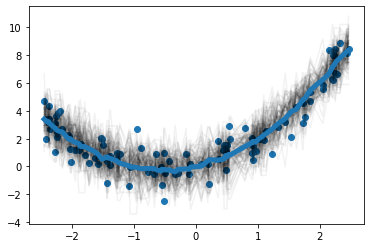

In [34]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(X, expected_prediction(DecisionTreeRegressor(), X), lw=5)

Podemos ver que en esperanza el modelo le pega muy bien, sin embargo en cada realizacion del dataset

### Como se ve con observaciones out of sample?

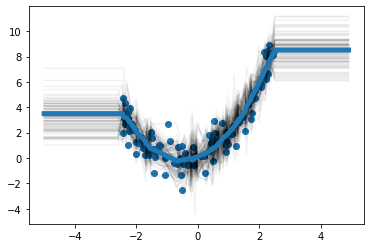

In [35]:
ys = sample_predictions(DecisionTreeRegressor(), oos_X)
plt.plot(oos_X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(oos_X, expected_prediction(DecisionTreeRegressor(), oos_X), lw=5)

En los datos que conoce, ajusta muy bien 

# Calculando sesgo y varianza

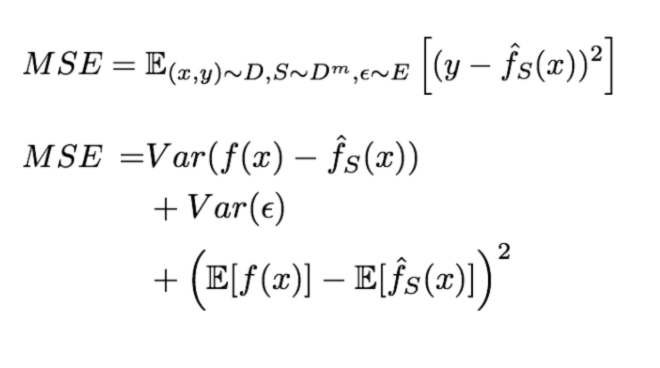

Recordar que en las esperanzas de la segunda ecuacion son sobre las variables que estan en la expresion de MSE.

En este caso, por construccion **sabemos** el valor de `E[f(x)]`.
Es decir `E[f(x)] = x^2 + x` (ver funcion sample_data)

Con eso podemos calcular el sesgo y la varianza para este caso

In [13]:
def bias(model, x, y, iters=1000):
    ideal_y = (x**2 + x).squeeze()
    errors = (
        ideal_y - expected_prediction(model, x, iters=iters)
    ) ** 2
    return errors.mean()

def variance(model, x, y, iters=1000):
    ideal_y = (x**2 + x).squeeze()
    # repetimos la esperanza en `iters` filas para facilitar el computo
    ideal_y = np.repeat(ideal_y.reshape((1, -1)), iters, axis=0)
    
    # sampleamos iters predicciones de modelos
    ys_hat = sample_predictions(model, x, iters=iters)
    
    # Estimamos la varianza por cada par (x_i, y_i) del dataset, luego promediamos las varianzas
    return np.var(ideal_y - ys_hat, axis=0).mean()

De esta forma podemos calcular el sesgo y la varianza de una regresion lineal

In [14]:
bias(
    LinearRegression(), 
    *sample_data(1000, x_matrix=True)
)

3.4581798677482367

In [15]:
variance(
    LinearRegression(), 
    *sample_data(1000, x_matrix=True)
)

0.11611537456618921

Tiene alto sesgo y baja varianza en el modelo. 

### Que pasa si jugamos con regularizacion L2?

A la regresion con regularizacion L2 se le suele llamar `Ridge`. El parámetro lambda en scikit-learn se llama alpha (a mas grande, mayor regularizacion)

In [36]:
from sklearn.linear_model import Ridge

L2Regression = Ridge

bias(
    Ridge(alpha=500), 
    *sample_data(1000, x_matrix=True)
)

4.118958892662329

In [37]:
variance(
    Ridge(alpha=500), 
    *sample_data(1000, x_matrix=True)
)

0.061758279812151005

Efectivamente tenemos menos varianza. Si regularizo sube el sesgo y baja la varianza. 

### Y podemos calcular el sesgo y la varianza de un decision tree

In [38]:
bias(
    DecisionTreeRegressor(min_samples_leaf=1), 
    *sample_data(1000, x_matrix=True), 
)

0.0011932185232604784

In [39]:
variance(
    DecisionTreeRegressor(min_samples_leaf=1), 
    *sample_data(1000, x_matrix=True), 
)

1.0041532064108267

Se puede ver que el decision tree tiene **muchisimo menos sesgo**, pero tiene una varianza 10 veces mas alta.

### Qué pasa si utilizamos min_samples_leaf = 10?

In [42]:
bias(
    DecisionTreeRegressor(min_samples_leaf=15), 
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

0.37477953230753347

In [46]:
variance(
    DecisionTreeRegressor(min_samples_leaf=10), 
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

0.3927931031305139

In [22]:
from ipywidgets import interact, widgets

def draw_predictions(min_samples_leaf):
    ys = sample_predictions(
        DecisionTreeRegressor(min_samples_leaf=min_samples_leaf), 
        oos_X,
        iters=100
    )
    plt.plot(oos_X, ys.T, color='k', alpha=0.05);
    plt.scatter(X, y)
    plt.plot(
        oos_X, 
        expected_prediction(
            DecisionTreeRegressor(min_samples_leaf=min_samples_leaf), 
            oos_X
        ), 
        lw=5
    )
    plt.xlim(-5, 5)
    plt.ylim(-4, 12)
    

interact(
    draw_predictions, 
    min_samples_leaf=widgets.IntSlider(min=1, max=50, step=1, value=10)
);

interactive(children=(IntSlider(value=10, description='min_samples_leaf', max=50, min=1), Output()), _dom_clas…

Si aumento el sesgo (llevo el min_sample a 50) La esperanza de la estimación de mi modelo es mala. 

Si le dejo que tenga mucho sesgo (llevo el min_sample a 1) la esperanza de la estimación es buena pero cada instanciación a cada data set se ajustara todo lo que pueda, se ajusta a las particularidades del data set (overfitting) y no generaliza. 

# Un modelo con el sesgo perfecto

Como machine learning practitioner se que preciso un modelo cuadratico para realizar el ajuste. 

In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Ajustamos un modelo cuadrático
model = make_pipeline(PolynomialFeatures(), LinearRegression())

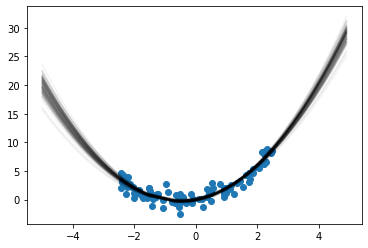

In [48]:
ys = sample_predictions(model, oos_X)
plt.plot(oos_X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

En este caso, al elegir el sesgo correcto, el modelo generaliza inclusive a datos nunca vistos de forma correcta.


En este caso tenemos un modelo de bajo sesgo y baja varianza (algo muy raro en la práctica). 

Si bien este es un ejemplo de juguete, sirve para ejemplificar como un sesgo introducido de forma correcta al problema puede ser muy beneficioso en la calidad del modelo final

In [51]:
bias(
    model,
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

2.6690342570669555e-05

In [50]:
variance(
    model,
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

0.03062248538726916

El sesgo esta muy por debajo de los modelos analizados anteriormente. 